## Distilling knowledge from ensemble of teachers to student with multi-head

### teachers trained:
1. Resnet14
2. Resnet20
3. Resnet32
4. Resnet44

### student model:
- Resnet20 without the last residual block as shared body and 2 res-blocks per head for 4 heads

In [0]:
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import scipy as sp
from scipy.stats import entropy

from nets.keras_resnet import resnet_v1, resnet_v2
from nets.student_model_multeacherKD import resnet20_student

In [0]:
# parameters

temperature = 4
seed = 6
batch_size = 32

In [0]:
# js_divergence

def JS_Divergence(softmaxes):
  softsum = np.zeros(softmaxes[0].shape)
  jsd = 0.0

  for i in softmaxes:
    j = np.asarray(i) 
    j = j/j.sum()
    softsum += j

  m = 1./3*softsum

  for i in softmaxes:
    j = np.asarray(i)
    jsd += sp.stats.entropy(j,m, base=np.e)/5.

  return jsd

In [0]:
def kd_loss(y_true, y_pred):

  '''
    Calculate modified Kullback-Leibler Divergence between ground truths and prediction.
  '''

  y_true_normal = y_true[:,:10]
  y_true_soft = y_true[:,10:]
  y_pred_normal = y_pred[:,:10]
  y_pred_soft = y_pred[:, 10:]

  alpha = 0.5
  t = temperature

  a = tf.keras.losses.kullback_leibler_divergence(y_pred_soft, y_true_soft) # kl divergence between softened logits of teacher and student
  b = tf.keras.losses.categorical_crossentropy(y_pred_normal, y_true_normal) # cross entropy between student's prediction and ground truth label

  return a*(alpha*t*t)+b*(1-alpha)


In [0]:
def multihead_kd_evaluate(y_true, y_pred):

    pred = []
    acc = []
    loss = []
    
    m = tf.keras.metrics.CategoricalAccuracy()

    for i in range(len(y_pred)):
      m(y_true, y_pred[i][:,:10])
      pred.append(y_pred[i][:,:10])
      acc.append(m.result().numpy()) 
      cce = tf.keras.losses.CategoricalCrossentropy()
      loss.append(cce(y_true, y_pred[i][:,:10]).numpy())
      m.reset_states

    pred = np.array(pred)
    avg_pred = pred.mean(axis=0)
    m(y_true, avg_pred)
    avg_acc = m.result().numpy()
    m.reset_states
    
    return (loss,acc, avg_acc)

In [0]:
def new_softmax(logits, temperature=1):

  '''
    temperatured softmax
  '''
  logits = logits/temperature
  return np.exp(logits)/np.sum(np.exp(logits))

In [0]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()
train_data, test_data = train_data.astype('float32')/255. , test_data.astype('float32')/255.
train_labels, test_labels = train_labels.astype('int32'), test_labels.astype('int32')

x_train_mean = np.mean(train_data, axis=0)
train_data -= x_train_mean
test_data -= x_train_mean

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

def random_shift(image):
    return  tf.keras.preprocessing.image.random_shift(image, 0.1, 0.1,  row_axis=0, col_axis=1, channel_axis=2)

def augment(image, label):
    image = tf.numpy_function(random_shift, [image], tf.float32)
    image = tf.image.random_flip_left_right(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_ds = train_ds.shuffle(10000, seed=seed)
train_ds = train_ds.map(augment)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
train_steps_per_epoch = tf.data.experimental.cardinality(train_ds)

test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

print(train_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 10)


## Resnet20

In [0]:
# Resnet 20
resnet_20 = resnet_v1(input_shape=(32,32,3), depth= 20, num_classes=10)
#resnet_20.summary()

In [0]:
def lr_schedule(epoch):
  lr = 1e-3
  if epoch>=10:
    lr*= 1e-1
  elif epoch>=25:
    lr*= 1e-2
  elif epoch>=40:
    lr*= 1e-3
  return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [0]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [0]:
resnet_20.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
rn20_hist = resnet_20.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler])

Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 1.5838 - accuracy: 0.4813
Epoch 00001: saving model to /content/drive/My Drive/MulTeacher Models/resnet_20_cp/cp.ckpt
1563/1563 [==============================] - 38s 24ms/step - loss: 1.5838 - accuracy: 0.4813 - val_loss: 1.5533 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 2/50
1561/1563 [============================>.] - ETA: 0s - loss: 1.2088 - accuracy: 0.6253
Epoch 00002: saving model to /content/drive/My Drive/MulTeacher Models/resnet_20_cp/cp.ckpt
1563/1563 [==============================] - 38s 24ms/step - loss: 1.2087 - accuracy: 0.6253 - val_loss: 1.2218 - val_accuracy: 0.6282 - lr: 0.0010
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.0432 - accuracy: 0.6897
Epoch 00003: saving model to /content/drive/My Drive/MulTeacher Models/resnet_20_cp/cp.ckpt
1563/1563 [==============================] - 37s 24ms/step - loss: 1.0433 - accuracy: 0.6896 - val_loss: 1.0677 - val_accuracy: 0.6758

In [0]:
resnet_20.evaluate(test_data, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.5206 - accuracy: 0.8748


[0.520627498626709, 0.8748000264167786]

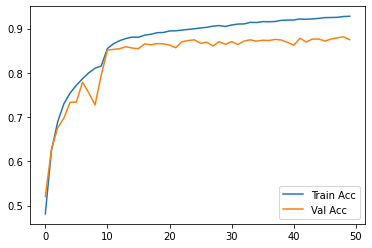

In [0]:
plt.figure()
plt.plot(rn20_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn20_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

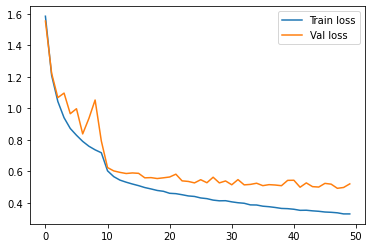

In [0]:
plt.figure()
plt.plot(rn20_hist.history['loss'], label= 'Train loss')
plt.plot(rn20_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

## Resnet32

In [0]:
# Resnet32

resnet_32 = resnet_v1(input_shape=(32,32,3), depth= 32, num_classes=10)
#resnet_32.summary()

In [0]:
resnet_32.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
rn32_hist = resnet_32.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler])

Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 1.7322 - accuracy: 0.4627
Epoch 00001: saving model to /content/drive/My Drive/MulTeacher Models/resnet_32_cp/cp.ckpt
1563/1563 [==============================] - 69s 44ms/step - loss: 1.7322 - accuracy: 0.4627 - val_loss: 1.5667 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.3152 - accuracy: 0.6111
Epoch 00002: saving model to /content/drive/My Drive/MulTeacher Models/resnet_32_cp/cp.ckpt
1563/1563 [==============================] - 68s 43ms/step - loss: 1.3152 - accuracy: 0.6111 - val_loss: 1.4596 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 1.1337 - accuracy: 0.6762
Epoch 00003: saving model to /content/drive/My Drive/MulTeacher Models/resnet_32_cp/cp.ckpt
1563/1563 [==============================] - 68s 44ms/step - loss: 1.1337 - accuracy: 0.6762 - val_loss: 1.3127 - val_accuracy: 0.6326

In [0]:
resnet_32.evaluate(test_data, test_labels)

313/313 [==============================] - 4s 12ms/step - loss: 0.5683 - accuracy: 0.8672


[0.5682622194290161, 0.8672000169754028]

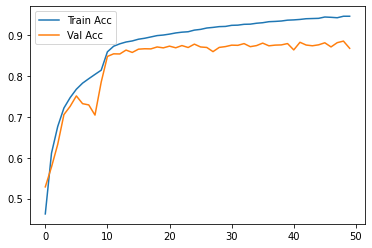

In [0]:
plt.figure()
plt.plot(rn32_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn32_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

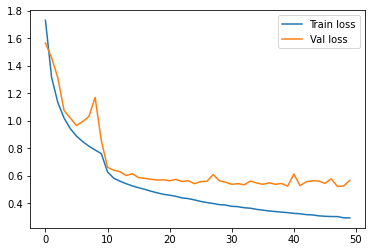

In [0]:
plt.figure()
plt.plot(rn32_hist.history['loss'], label= 'Train loss')
plt.plot(rn32_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

## Resnet14

In [0]:
# Resnet14

resnet_14 = resnet_v1(input_shape=(32,32,3), depth=14, num_classes=10)
#resnet_14.summary()

In [0]:
resnet_14.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
rn14_hist = resnet_14.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler])

Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.5042 - accuracy: 0.4962
Epoch 00001: saving model to /content/drive/My Drive/MulTeacher Models/resnet_14_cp/cp.ckpt
1563/1563 [==============================] - 61s 39ms/step - loss: 1.5041 - accuracy: 0.4963 - val_loss: 1.3119 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.1613 - accuracy: 0.6292
Epoch 00002: saving model to /content/drive/My Drive/MulTeacher Models/resnet_14_cp/cp.ckpt
1563/1563 [==============================] - 61s 39ms/step - loss: 1.1612 - accuracy: 0.6292 - val_loss: 1.2809 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.0035 - accuracy: 0.6885
Epoch 00003: saving model to /content/drive/My Drive/MulTeacher Models/resnet_14_cp/cp.ckpt
1563/1563 [==============================] - 61s 39ms/step - loss: 1.0034 - accuracy: 0.6886 - val_loss: 1.0187 - val_accuracy: 0.6912

In [0]:
resnet_14.evaluate(test_data, test_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.5394 - accuracy: 0.8612


[0.5393701195716858, 0.8611999750137329]

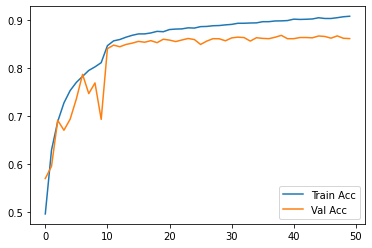

In [0]:
plt.figure()
plt.plot(rn14_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn14_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

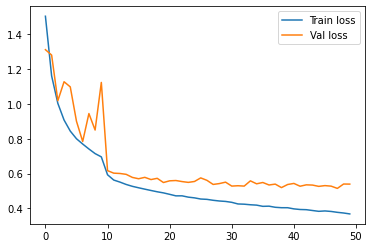

In [0]:
plt.figure()
plt.plot(rn14_hist.history['loss'], label= 'Train loss')
plt.plot(rn14_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

## Resnet44

In [0]:
# Resnet44

resnet_44 = resnet_v1(input_shape=(32,32,3), depth=44, num_classes=10)
#resnet_44.summary()

In [0]:
resnet_44.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
rn44_hist = resnet_44.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler])

Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.9058 - accuracy: 0.4307
Epoch 00001: saving model to /content/drive/My Drive/MulTeacher Models/resnet_44_cp/cp.ckpt
1563/1563 [==============================] - 91s 58ms/step - loss: 1.9056 - accuracy: 0.4308 - val_loss: 1.7200 - val_accuracy: 0.4999 - lr: 0.0010
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.4420 - accuracy: 0.5877
Epoch 00002: saving model to /content/drive/My Drive/MulTeacher Models/resnet_44_cp/cp.ckpt
1563/1563 [==============================] - 90s 58ms/step - loss: 1.4420 - accuracy: 0.5878 - val_loss: 1.6542 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.2239 - accuracy: 0.6619
Epoch 00003: saving model to /content/drive/My Drive/MulTeacher Models/resnet_44_cp/cp.ckpt
1563/1563 [==============================] - 90s 57ms/step - loss: 1.2239 - accuracy: 0.6619 - val_loss: 1.4691 - val_accuracy: 0.6014

In [0]:
resnet_44.evaluate(test_data, test_labels)

313/313 [==============================] - 5s 16ms/step - loss: 0.5796 - accuracy: 0.8735


[0.5796104073524475, 0.8734999895095825]

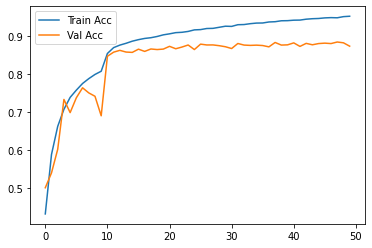

In [0]:
plt.figure()
plt.plot(rn44_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn44_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

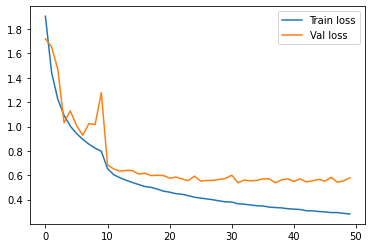

In [0]:
plt.figure()
plt.plot(rn44_hist.history['loss'], label= 'Train loss')
plt.plot(rn44_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

## Teachers' logits extractions

In [0]:
# Resnet20

model_sans_softmax = keras.models.Model(inputs=resnet_20.input, outputs = resnet_20.get_layer('logits').output)
new_logits = model_sans_softmax.predict(train_data)
unsoftened_prob = new_softmax(new_logits, 1)
print("Unsoftened probabilities " + str(unsoftened_prob[0]))
temperature = 4
rn20_softened_prob = new_softmax(new_logits, temperature)


In [0]:
rn20_train_labels = np.hstack([train_labels, rn20_softened_prob])
print(rn20_train_labels.shape)

(50000, 20)


In [0]:
# Resnet14

model_sans_softmax = keras.models.Model(inputs=resnet_14.input, outputs = resnet_14.get_layer('logits').output)
new_logits = model_sans_softmax.predict(train_data)
unsoftened_prob = new_softmax(new_logits, 1)
print("Unsoftened probabilities " + str(unsoftened_prob[0]))
temperature = 4
rn14_softened_prob = new_softmax(new_logits, temperature)


In [0]:
rn14_train_labels = np.hstack([train_labels, rn14_softened_prob])
print(rn14_train_labels.shape)

(50000, 20)


In [0]:
# Resnet32

model_sans_softmax = keras.models.Model(inputs=resnet_32.input, outputs = resnet_32.get_layer('logits').output)
new_logits = model_sans_softmax.predict(train_data)
unsoftened_prob = new_softmax(new_logits, 1)
print("Unsoftened probabilities " + str(unsoftened_prob[0]))
temperature = 4
rn32_softened_prob = new_softmax(new_logits, temperature)


In [0]:
rn32_train_labels = np.hstack([train_labels, rn32_softened_prob])
print(rn32_train_labels.shape)

(50000, 20)


In [0]:
# Resnet44

model_sans_softmax = keras.models.Model(inputs=resnet_44.input, outputs = resnet_44.get_layer('logits').output)
new_logits = model_sans_softmax.predict(train_data)
unsoftened_prob = new_softmax(new_logits, 1)
print("Unsoftened probabilities " + str(unsoftened_prob[0]))
temperature = 4
rn44_softened_prob = new_softmax(new_logits, temperature)


In [0]:
rn44_train_labels = np.hstack([train_labels, rn44_softened_prob])
print(rn44_train_labels.shape)

(50000, 20)


## Student Model

In [0]:
# Student Model

temperature = 4
student = resnet20_student((32,32,3), temperature=temperature, num_classes=10)
#student.summary()

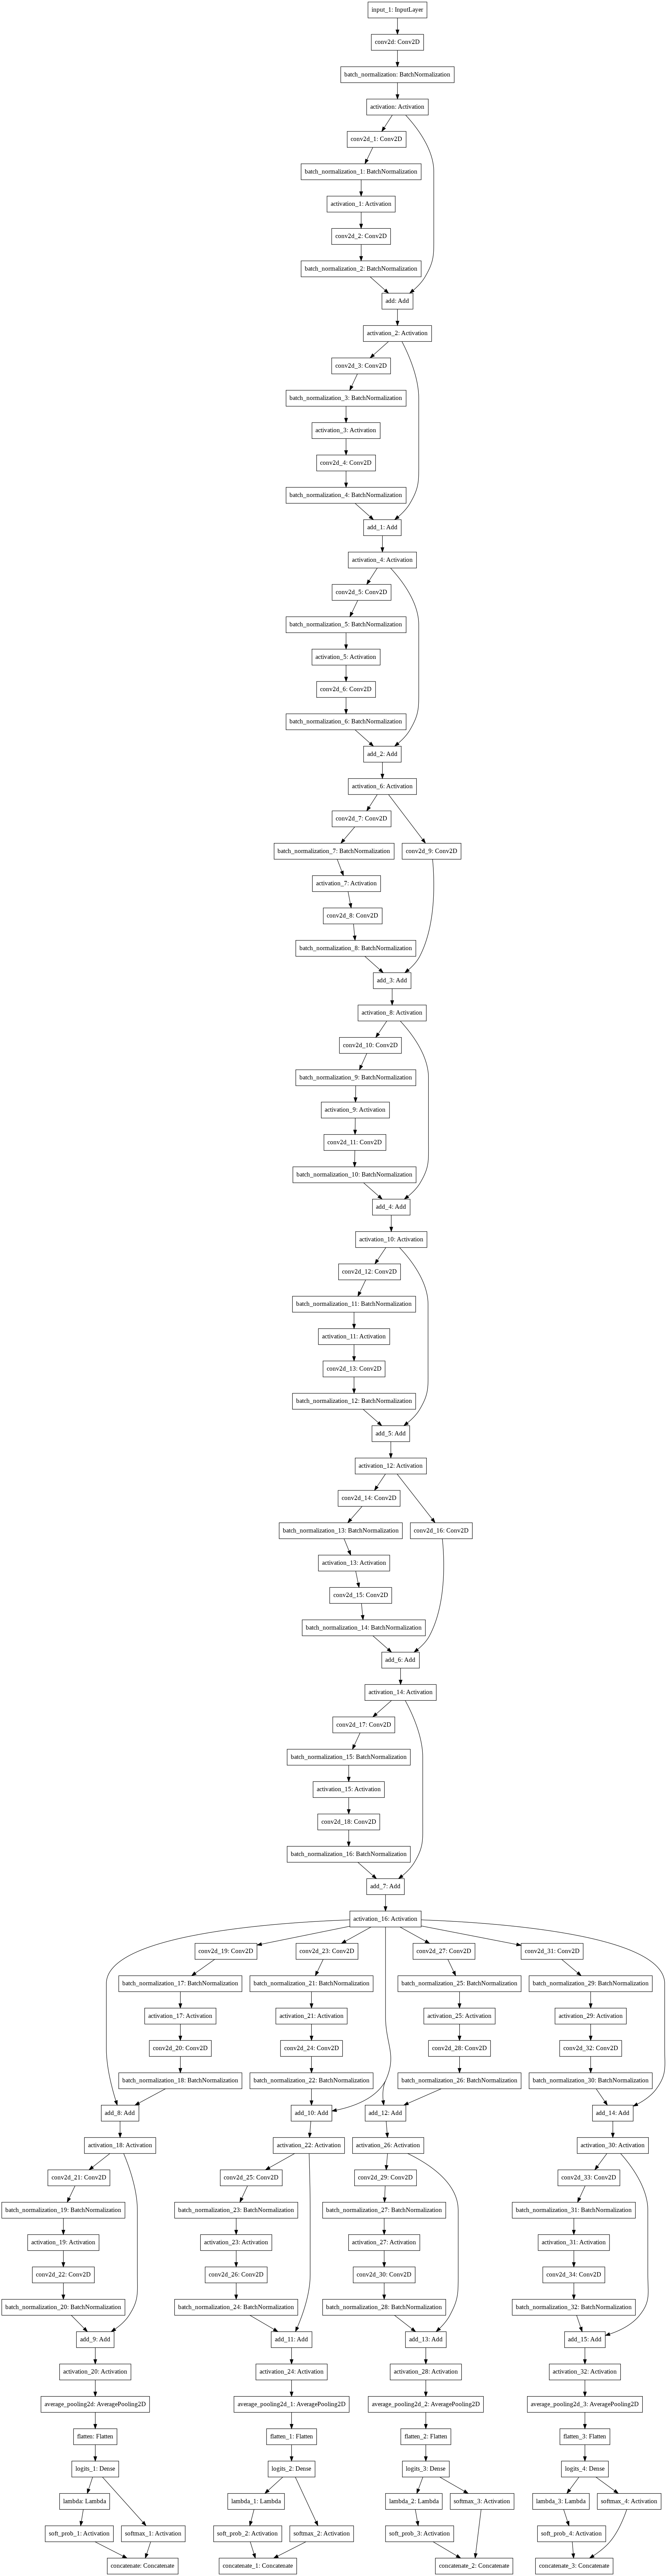

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(student)

## Student Model Training

In [0]:
student.compile(optimizer='adam', loss=kd_loss, metrics=['accuracy'])

In [0]:
student.fit(train_data, [rn14_train_labels, rn20_train_labels, rn32_train_labels, rn44_train_labels], epochs=50, callbacks=[student_cp])

Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 388.0385 - concatenate_loss: 96.0429 - concatenate_1_loss: 96.5329 - concatenate_2_loss: 96.9720 - concatenate_3_loss: 98.1071 - concatenate_accuracy: 0.5060 - concatenate_1_accuracy: 0.5068 - concatenate_2_accuracy: 0.5009 - concatenate_3_accuracy: 0.5017
Epoch 00001: saving model to /content/drive/My Drive/MulTeacher Models/students/combined_cp/cp.ckpt
1563/1563 [==============================] - 67s 43ms/step - loss: 388.0385 - concatenate_loss: 96.0429 - concatenate_1_loss: 96.5329 - concatenate_2_loss: 96.9720 - concatenate_3_loss: 98.1071 - concatenate_accuracy: 0.5060 - concatenate_1_accuracy: 0.5068 - concatenate_2_accuracy: 0.5009 - concatenate_3_accuracy: 0.5017
Epoch 2/50
1563/1563 [==============================] - ETA: 0s - loss: 375.8796 - concatenate_loss: 93.2610 - concatenate_1_loss: 93.5696 - concatenate_2_loss: 93.9011 - concatenate_3_loss: 94.6815 - concatenate_accuracy: 0.6649 - concatenate_1_a

## Student Accuracy

In [0]:
pred = student(test_data)
(loss, acc, avg_acc) = multihead_kd_evaluate(test_labels, pred)
print(acc, avg_acc)

[0.8444, 0.84585, 0.8454, 0.845] 0.8455


## Teacher Ensemble Accuracy

In [0]:
# Teacher Ensemble Accuracy


models = [resnet_14, resnet_20, resnet_32, resnet_44]

preds = [model(test_data) for model in models]

preds = np.array(preds)

print(preds.shape)

avg_pred = preds.mean(axis=0)

m = tf.keras.metrics.CategoricalAccuracy() 
m(test_labels, avg_pred)
acc = m.result().numpy() 

print(acc)

(4, 10000, 10)
0.8907


## Teacher Divergence Values

In [0]:
# Teacher Divergence Values Calculation 

al_preds = [model(train_data[:5000]) for model in models]

al_preds = np.array(al_preds)

al_preds = al_preds.transpose((1,0,2))

print(al_preds.shape)

(5000, 4, 10)


In [0]:
teacher_divs = [JS_Divergence(ap) for ap in al_preds]
print(len(teacher_divs))
print(teacher_divs[:10])

5000
[0.447121093094148, 0.4492438846192602, 0.44908875825052685, 0.4493892586606517, 0.44986073145437916, 0.44981360509840845, 0.004510022771872559, 0.446490196097466, 0.44886994696393717, 0.4598215150320355]


## Student Divergence Values

In [0]:
stu_preds = student(train_data[:5000])

al_preds = np.array(stu_preds)

al_preds = al_preds.transpose((1,0,2))

print(al_preds.shape)


(5000, 4, 20)


In [0]:
stu_divs = [JS_Divergence(ap) for ap in al_preds]
print(len(stu_divs))
print(stu_divs[:10])

5000
[0.03695361540009206, 0.10280853146807115, 0.03819568876950261, 0.029603291032185564, 0.4676827627822896, 0.4396880531579922, 0.03323903131723687, 0.08632067416109647, 0.06079728973463746, 0.019592176513936334]


## Similarity between Teacher and Student Divergence Values

In [0]:
from scipy import spatial

result = 1 - spatial.distance.cosine(teacher_divs, stu_divs)
print(result)

0.6359644552334304


## Plain Student Training

In [0]:
student_plain = resnet20_student((32,32,3), temperature=1, num_classes=10)

inputs = student_plain.input
softmax1 = student_plain.get_layer('softmax_1').output
softmax2 = student_plain.get_layer('softmax_2').output
softmax3 = student_plain.get_layer('softmax_3').output
softmax4 = student_plain.get_layer('softmax_4').output

outputs = [softmax1, softmax2, softmax3, softmax4]

student_plain = tf.keras.models.Model(inputs=inputs, outputs=outputs)
#student_plain.summary()

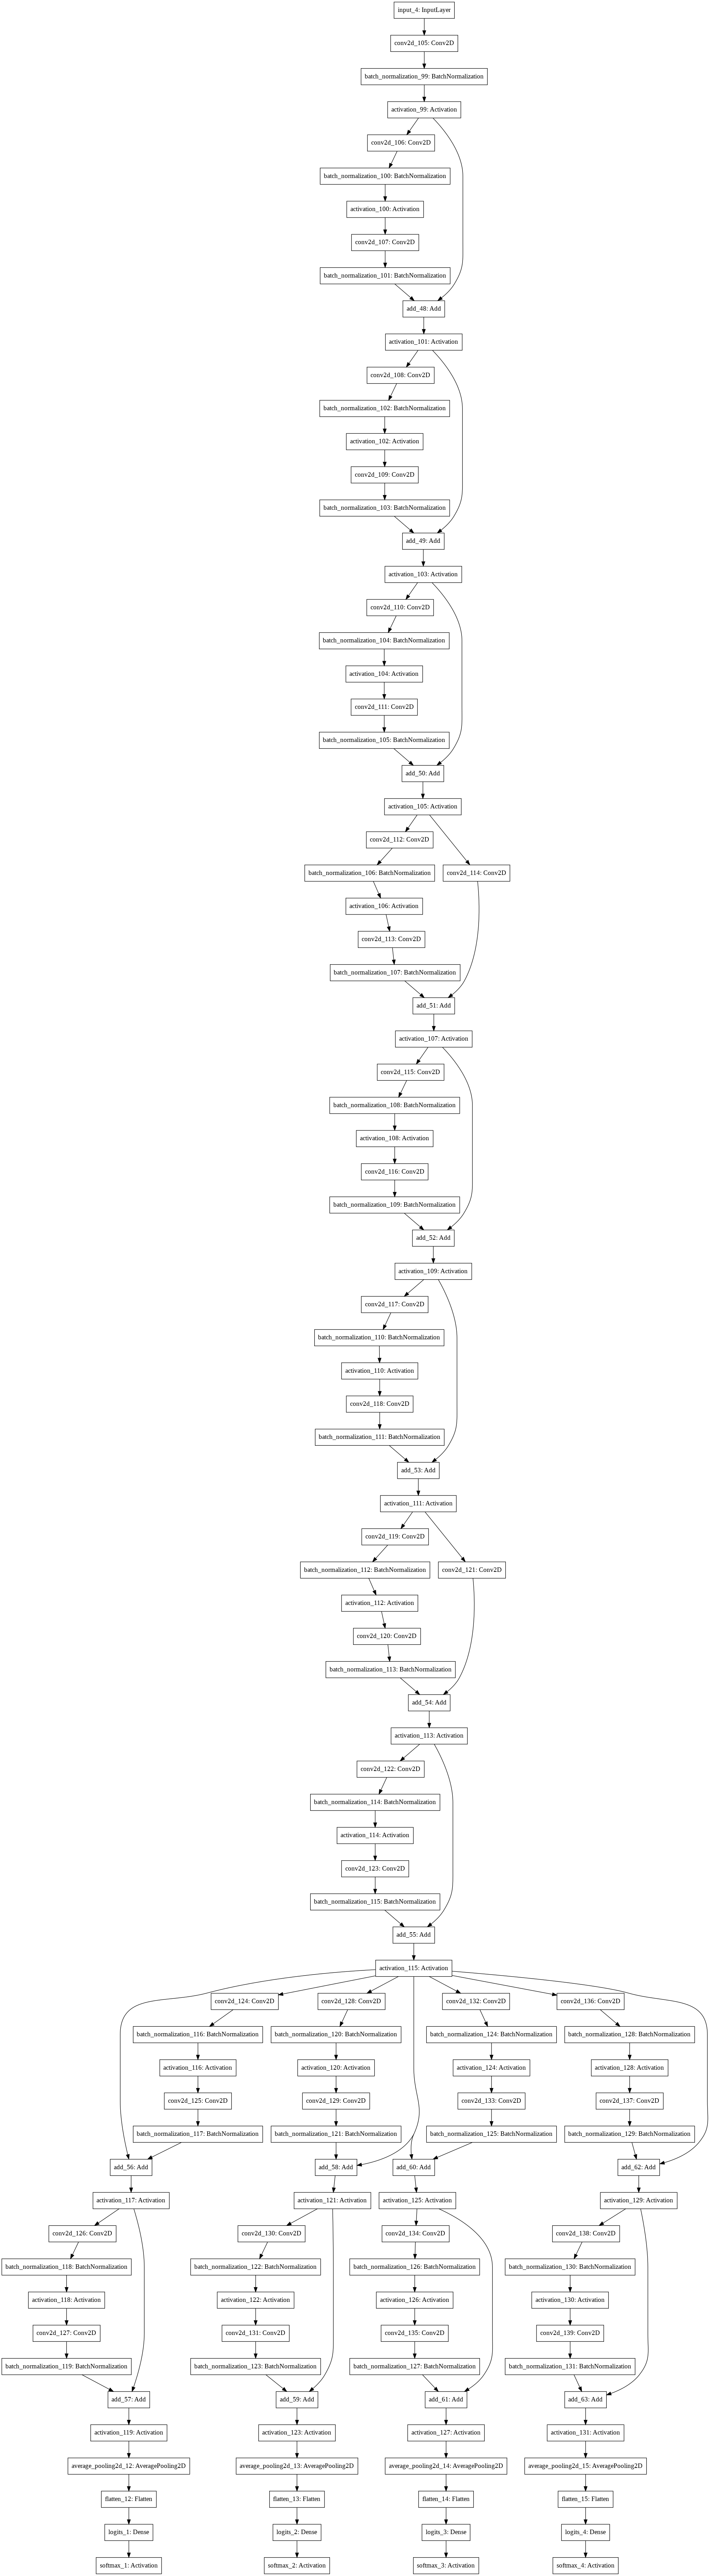

In [0]:
plot_model(student_plain)

In [0]:
student_plain.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
student_plain.fit(train_data, [train_labels, train_labels, train_labels, train_labels], epochs=50, callbacks=[plain_cp, lr_scheduler])

Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 5.8136 - softmax_1_loss: 1.3674 - softmax_2_loss: 1.3674 - softmax_3_loss: 1.3673 - softmax_4_loss: 1.3673 - softmax_1_accuracy: 0.5015 - softmax_2_accuracy: 0.5014 - softmax_3_accuracy: 0.5014 - softmax_4_accuracy: 0.5011
Epoch 00001: saving model to /content/drive/My Drive/MulTeacher Models/students/plain_cp/cp.ckpt
1563/1563 [==============================] - 77s 49ms/step - loss: 5.8133 - softmax_1_loss: 1.3673 - softmax_2_loss: 1.3673 - softmax_3_loss: 1.3672 - softmax_4_loss: 1.3672 - softmax_1_accuracy: 0.5016 - softmax_2_accuracy: 0.5015 - softmax_3_accuracy: 0.5015 - softmax_4_accuracy: 0.5011 - lr: 0.0010
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 4.1337 - softmax_1_loss: 0.9451 - softmax_2_loss: 0.9451 - softmax_3_loss: 0.9451 - softmax_4_loss: 0.9452 - softmax_1_accuracy: 0.6659 - softmax_2_accuracy: 0.6656 - softmax_3_accuracy: 0.6654 - softmax_4_accuracy: 0.6658
Epoch 0000

In [0]:
pred = student_plain(test_data)
(loss, acc, avg_acc) = multihead_kd_evaluate(test_labels, pred)
print(acc, avg_acc)

[0.8093, 0.8073, 0.8062, 0.8061] 0.80656
